<a href="https://colab.research.google.com/github/jgdshkovi/Benn/blob/master/similar_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from pylab import rcParams
import warnings

sns.set_color_codes()
sns.set_context('poster')
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10,5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%cd /content/drive/My Drive/Z/filter_pruning
from models import *
import spherical_kmeans as skm

/content/drive/My Drive/Z/filter_pruning


In [0]:
model = torch.load('logs/model_best.pth.tar')
checkpoint = torch.load('logs/checkpoint.pth.tar')

In [5]:
model = vgg(dataset='cifar10', depth=16)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

torch.Size([64, 3, 3, 3])
[162.92686, 138.03294, 115.0706, 103.07436, 94.94717, 89.683624, 79.17703, 72.3799, 68.92973, 61.88436, 55.92576, 52.92383, 52.116337, 47.420074, 42.09857, 40.061737, 39.02826, 36.201225, 34.637714, 29.957275, 28.998478, 26.607553, 24.82565, 24.471607, 22.355457, 20.283672, 18.946846, 17.120312, 15.707512, 15.53673, 14.081871, 12.586693, 11.552683, 11.199465, 9.74263, 9.517868, 9.1698, 8.160339, 7.4563246, 7.1701345, 6.71568, 5.8344254, 5.538031, 5.112393, 4.4722886, 3.8476424, 3.730368, 3.3111296, 2.7895596, 2.644308, 2.2931557, 2.0105495, 1.7822958, 1.5657904, 1.3150954, 1.1256804, 0.9212744, 0.7394254, 0.5766382, 0.419171, 0.2858158, 0.17043455, 0.083903395, 1.6653345e-14]


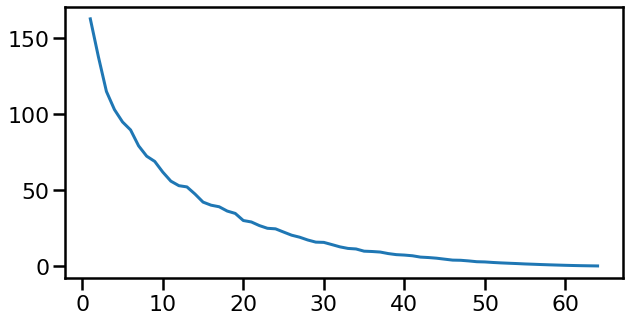

In [37]:
ress = []
X = []
for m in model.modules():
  if isinstance(m , nn.Conv2d):
    shape = m.weight.data.shape
    print(shape)
    reshaped_tensor = m.weight.data.clone().numpy().reshape(shape[0] , shape[1]*shape[2]*shape[3])
    X = reshaped_tensor
    K = range(1,shape[0]+1)
    dist_points_from_cluster_center = []
    for no_of_clusters in K:
      res = skm.spherical_k_means(X,n_clusters=no_of_clusters)
      ress.append(res[1])
      dist_points_from_cluster_center.append(res[2])

    print(dist_points_from_cluster_center)
    plt.plot(K, dist_points_from_cluster_center)
    break

In [0]:
def calc_distance(x1, y1, a, b, c):
  d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
  return d

In [0]:
a = dist_points_from_cluster_center[0] - dist_points_from_cluster_center[63]
b = K[63] - K[0]
c1 = K[0] * dist_points_from_cluster_center[63]
c2 = K[63] * dist_points_from_cluster_center[0]
c = c1 - c2

In [0]:
distance_of_points_from_line = []
for k in range(64):
  distance_of_points_from_line.append(
      calc_distance(K[k], dist_points_from_cluster_center[k], a, b, c))

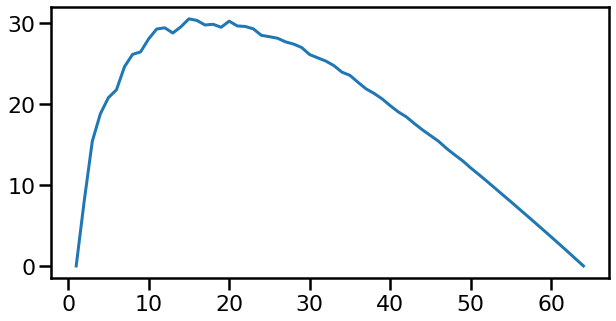

In [41]:
plt.plot(K, distance_of_points_from_line)

In [44]:
max_dis_ind = distance_of_points_from_line.index(max(distance_of_points_from_line))
max_dis_ind

14

In [43]:
ress[max_dis_ind]

array([14,  0,  3,  9,  0, 14,  0,  9,  6,  9,  0, 10,  0,  0,  2,  3,  0,
        3,  2,  3,  3, 14,  0,  0,  3,  9,  9, 14,  0, 11,  2,  3,  3,  7,
        6,  0,  1,  0,  3,  3,  0,  0,  6, 14,  3,  0,  3,  0, 14, 12,  3,
        2,  4,  0, 14,  5,  9,  4,  0,  0,  6, 13, 14,  8], dtype=int32)

In [45]:
print(X[0])
print(X[5])

[-0.20329759 -0.2912947  -0.15875448 -0.4502149  -0.46539706 -0.3355868
 -0.40248287 -0.4745434  -0.36043137 -0.10599428 -0.1178368   0.01662677
 -0.2434322  -0.2329341  -0.07560349 -0.35403982 -0.3402888  -0.26939708
  0.20197837  0.4592037   0.51661384  0.25861105  0.426074    0.5360691
  0.16354738  0.26960593  0.37787127]
[-0.11040525  0.2486664   0.22107255 -0.16618459  0.26984513  0.22435495
 -0.35501167 -0.1570741  -0.06416202 -0.42072827  0.09566244  0.23722015
 -0.39706457  0.2022598   0.2121238  -0.5351144  -0.33211562 -0.19078048
 -0.24876417  0.38027808  0.36718726  0.02023249  0.7528788   0.6134622
 -0.37027356  0.06775948  0.10666069]


In [0]:
cos = nn.CosineSimilarity()

In [52]:
a = torch.from_numpy(np.reshape(X[0],(1,X[0].size)))
b = torch.from_numpy(np.reshape(X[5],(1,X[5].size)))
c = torch.from_numpy(np.reshape(X[21],(1,X[5].size)))
print(cos(a,b))
print(cos(a,c))

tensor([0.4953])
tensor([0.4097])
tensor([0.8204])


In [57]:
over = []
correlation = []
for i in ress[max_dis_ind]:
  for j in ress[max_dis_ind]:
    if i!=j and ress[max_dis_ind][i]==ress[max_dis_ind][j]:
      s = set((i,j))
      if s not in over:
        over.append(s)
        a = torch.from_numpy(np.reshape(X[i],(1,X[i].size)))
        b = torch.from_numpy(np.reshape(X[j],(1,X[j].size)))
        #print (i,j,cos(a,b))
        correlation.append([i,j,cos(a,b)])

print(over)

[{0, 5}, {9, 3}, {3, 7}, {9, 7}, {10, 6}, {1, 6}, {12, 6}, {4, 6}, {13, 6}, {1, 10}, {10, 12}, {10, 4}, {10, 13}, {1, 12}, {1, 4}, {1, 13}, {12, 4}, {12, 13}, {4, 13}]


In [70]:
#print(correlation)
threshold = 0.5
for item in correlation:
  if item[2]>=threshold:
    print(item)


[3, 9, tensor([0.6001])]
[3, 7, tensor([0.6781])]
[9, 7, tensor([0.8791])]
[6, 10, tensor([0.9496])]
[6, 1, tensor([0.6893])]
[6, 12, tensor([0.8795])]
[6, 13, tensor([0.5680])]
[10, 1, tensor([0.6910])]
[10, 12, tensor([0.9086])]
[10, 13, tensor([0.6166])]
[1, 12, tensor([0.6971])]
[12, 13, tensor([0.5504])]
